In [1]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt
from libpysal.weights import Kernel
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans

cf.go_offline()
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')

data = gpd.read_file(DATA_DIR / 'spatial_income_1880.gpkg')
data['is_old'] = data.is_old.astype(int)
pca_transformed = pd.read_csv(DATA_DIR / 'pca_transformed.csv', index_col=0).drop(columns=['geometry'])
data = data.join(pca_transformed)
data = data.drop(index=data[data.population < 5].index).dropna().reset_index()
# W = Kernel.from_dataframe(data, fixed=True, bandwidth=150, function='quartic')
xy = np.array([data.geometry.x, data.geometry.y]).T
d = distance_matrix(xy, xy)
d_norm = d / d.max()
n = data.shape[0]

SEED = 42
N_CLUSTERS = len(data.group.unique())

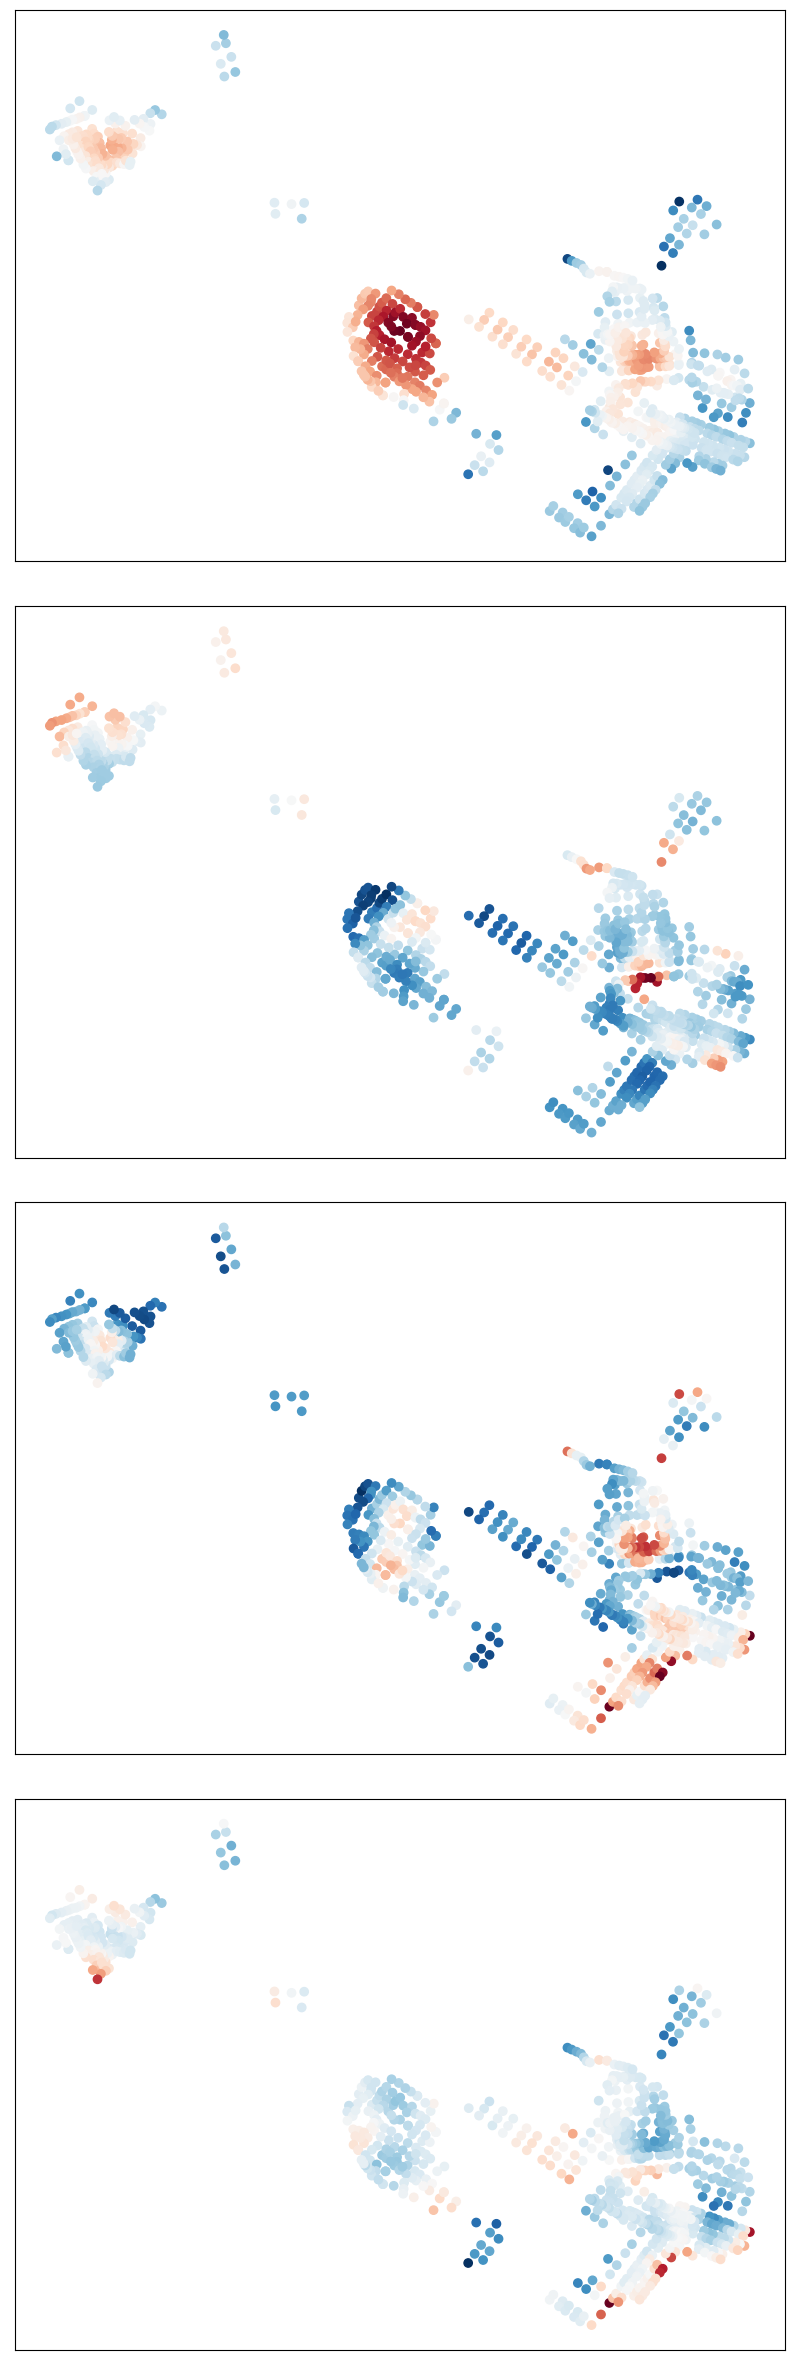

In [3]:
fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(4, 1, figsize=(8, 24), subplot_kw={'xticks': [], 'yticks':[]})
data.plot(
    column='1',
    cmap='RdBu',
    ax=ax_1,
)
data.plot(
    column='2',
    cmap='RdBu_r',
    ax=ax_2,
)
data.plot(
    column='3',
    cmap='RdBu_r',
    ax=ax_3,
)
data.plot(
    column='4',
    cmap='RdBu_r',
    ax=ax_4,
)
fig.tight_layout()
plt.show()

In [4]:
with pm.Model() as model_1:
    W = pm.MutableData('W', -data['3'])

    β_P = pm.MvNormal('β_P', np.array([0, 0]), np.array(np.diagflat([0.1, 0.1])), shape=2)

    μ_P = β_P[0] + β_P[1] * W
    σ_P = pm.Exponential('σ_P', 1)
    P = pm.Normal('P', mu=μ_P, sigma=σ_P, observed=-data['1'])

    β_O = pm.MvNormal('β_O', np.array([0, 0, 0]), np.array(np.diagflat([0.1, 0.1, 0.1])), shape=3)

    μ_O = β_O[0] + β_O[1] * W + β_O[2] * μ_P
    σ_O = pm.Exponential('σ_O', 1)
    O = pm.Normal('O', mu=μ_O, sigma=σ_O, observed=data['2'])

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

Sampling: [O, P, β_O, β_P, σ_O, σ_P]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_P, σ_P, β_O, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Sampling: [O, P]


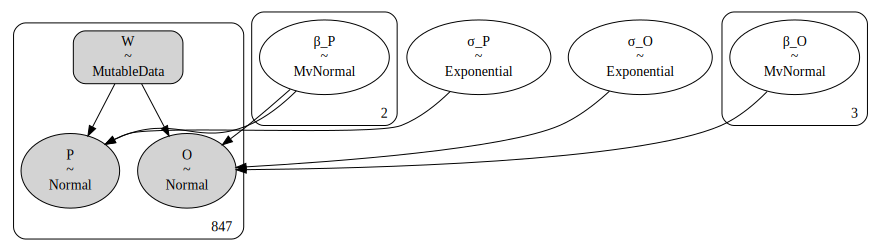

In [5]:
graph_1 = pm.model_to_graphviz(model_1)
graph_1

array([<AxesSubplot: xlabel='P / P'>, <AxesSubplot: xlabel='O / O'>],
      dtype=object)

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



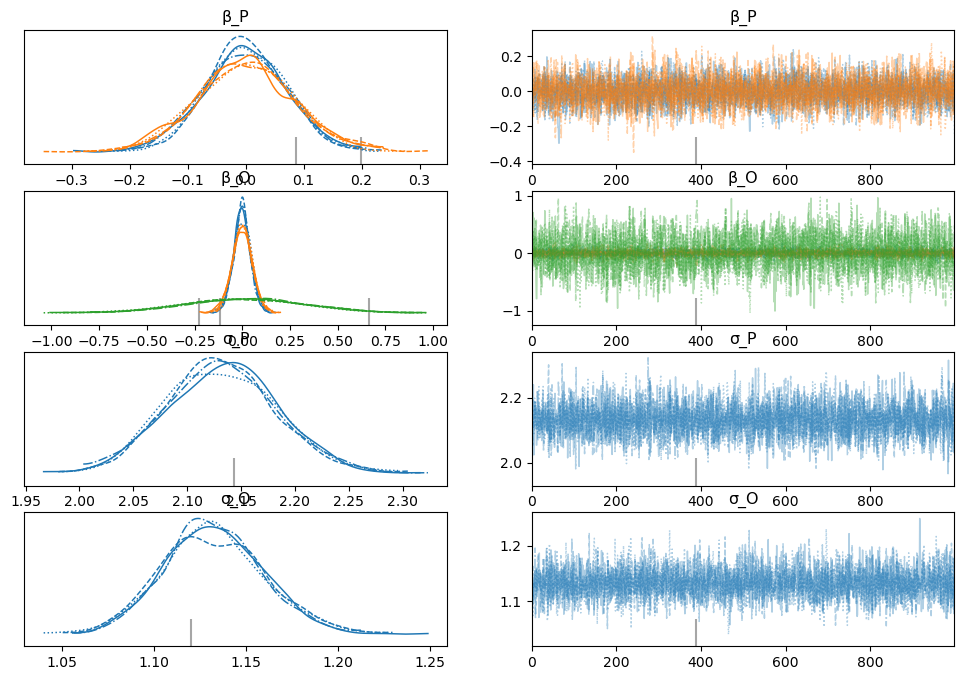

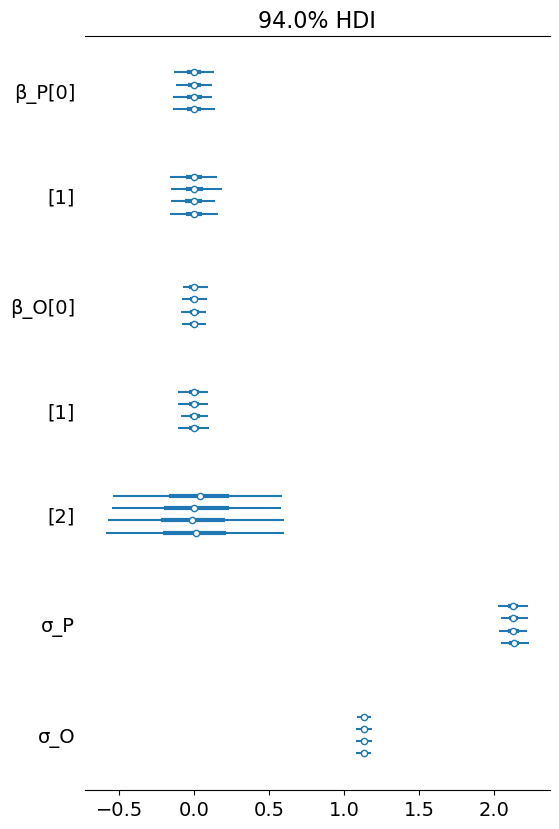

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



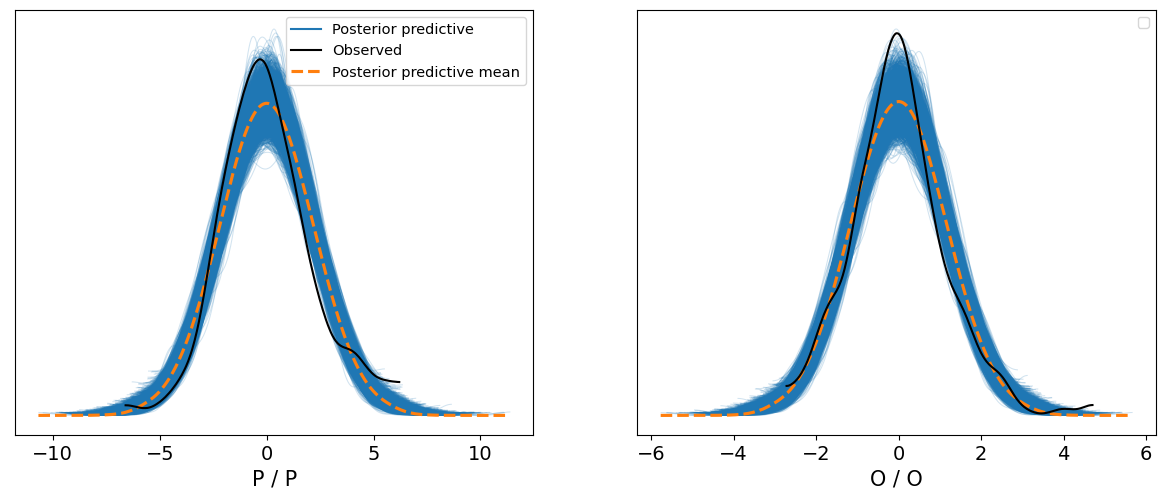

In [6]:
# az.plot_posterior(posterior_1)
az.plot_trace(posterior_1)
az.plot_forest(posterior_1, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_1)

# Clustering

<AxesSubplot: >

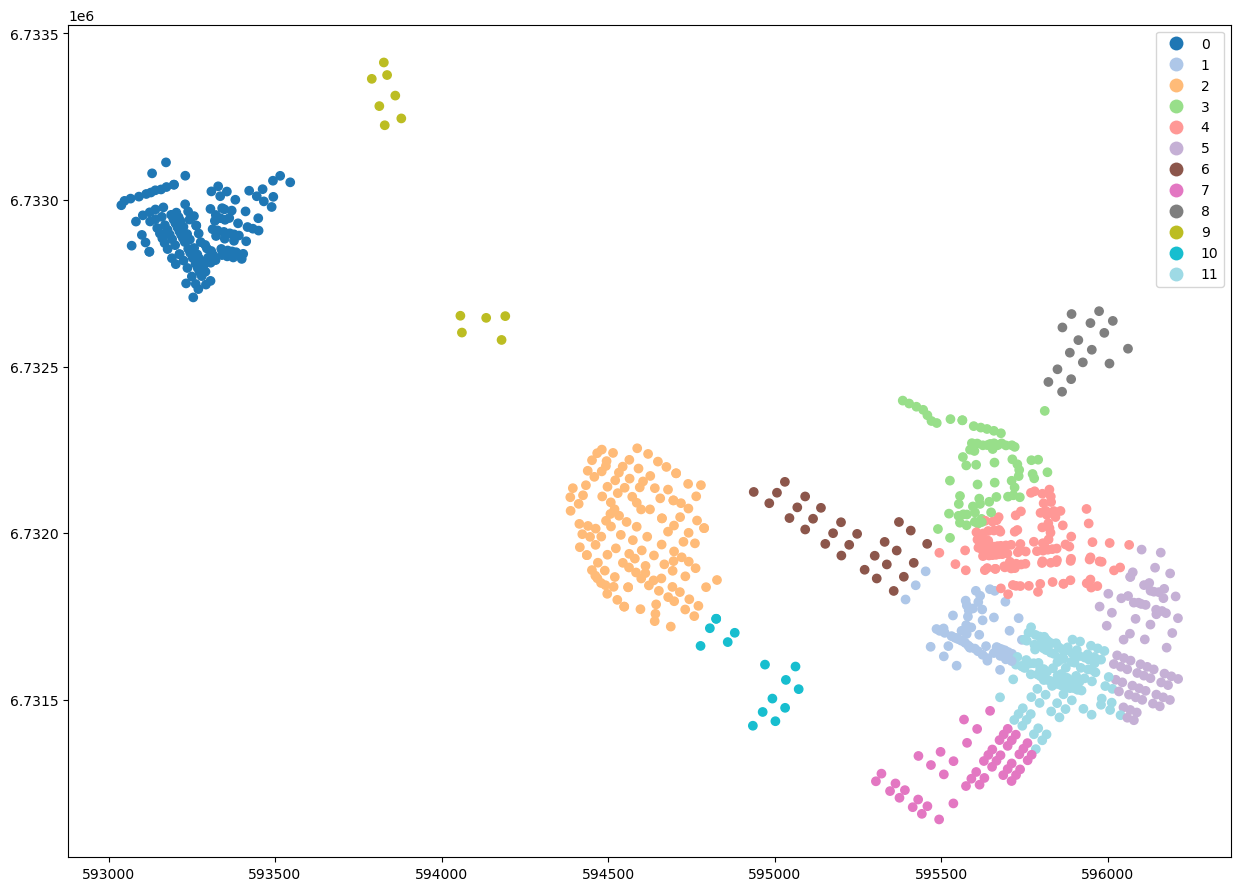

In [7]:
cluster_colors = plt.get_cmap('tab20')
data.plot(
    column='group',
    categorical=True,
    cmap=cluster_colors,
    figsize=(15, 15),
    legend=True,
)

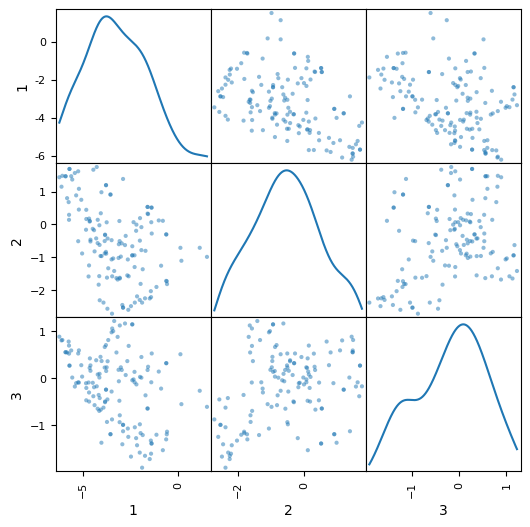

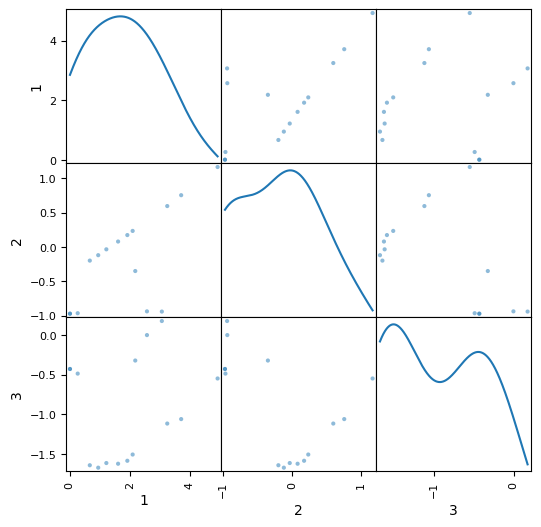

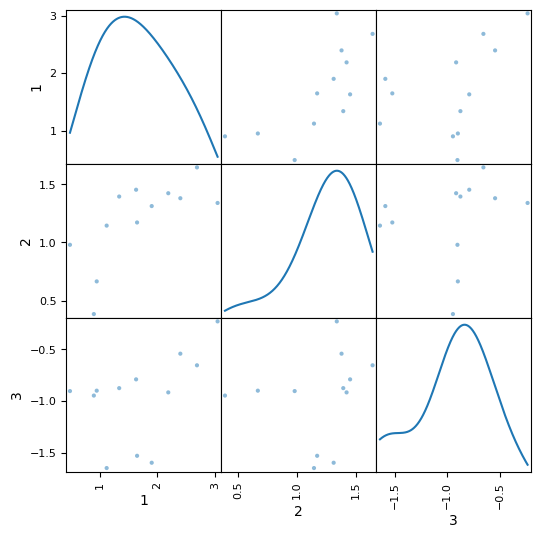

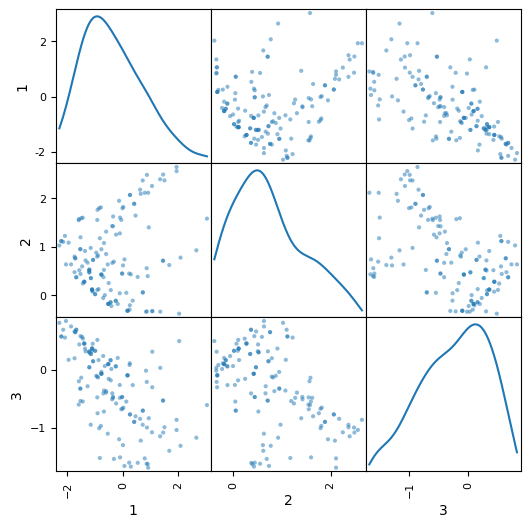

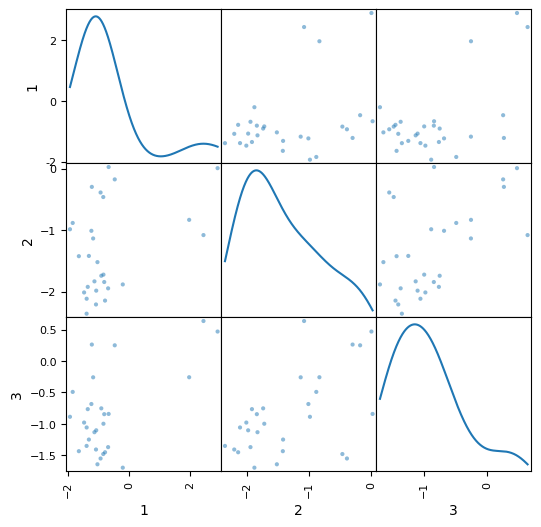

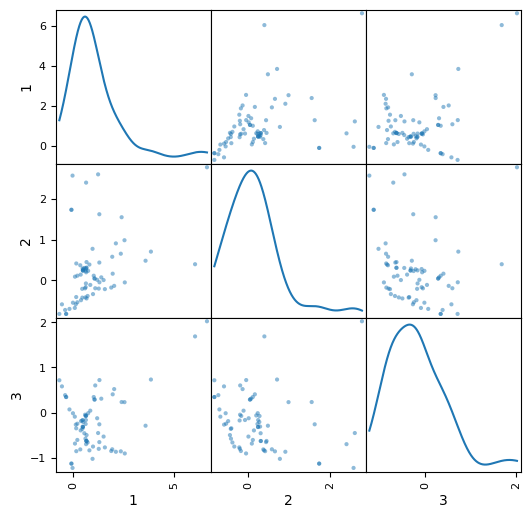

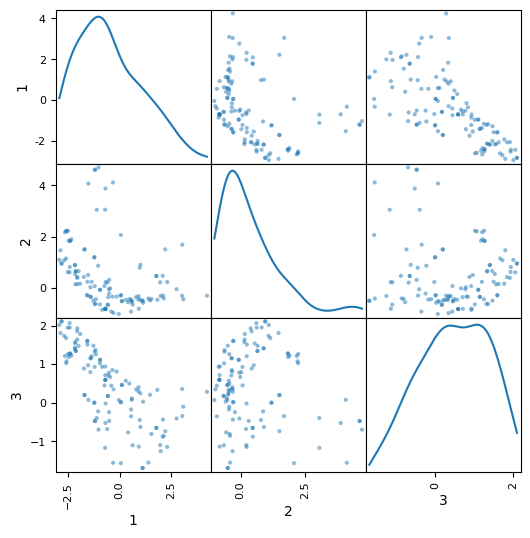

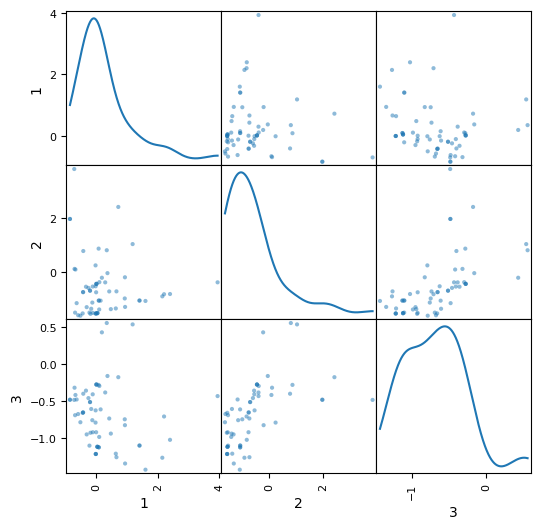

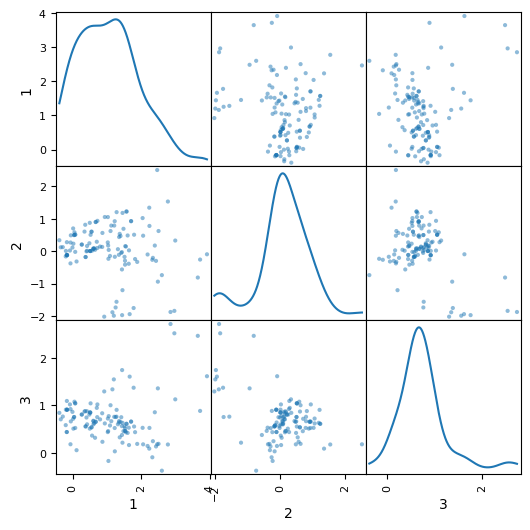

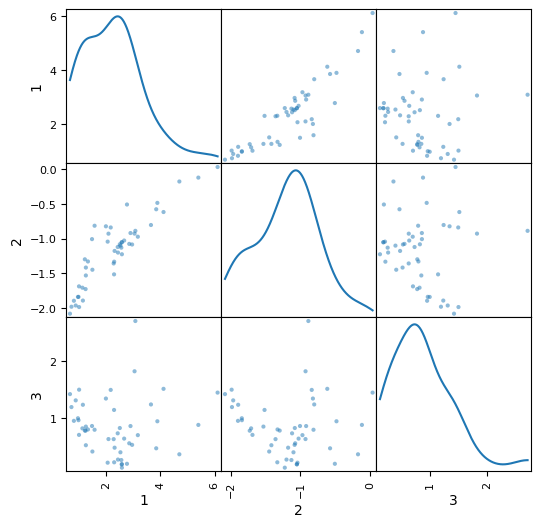

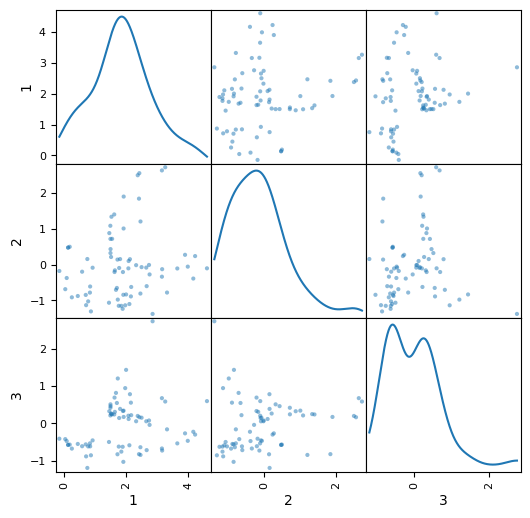

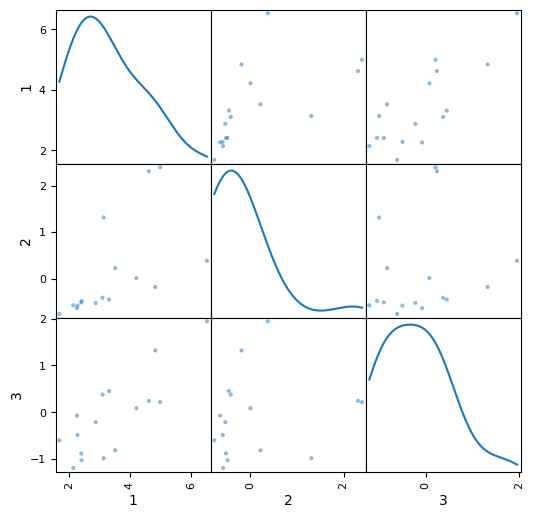

In [8]:
for i in data.group.unique():
    scatter_matrix(data.loc[data.group == i, ['1', '2', '3']], diagonal='kde', figsize=(6, 6))

# Model with 12 geographical clusters (K-means)

$$ P_i \sim N(μ_{P,i}, σ_P), i = 0, 1, ... 846 $$
$$ O_i \sim N(μ_{O,i}, σ_O), i = 0, 1, ... 846 $$
$$ μ_{P,i} = [1 \; W]  β_{P,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ μ_{O,i} = [1 \; W \; μ_{P,i}]  β_{O,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ σ_P \sim Exp(1) $$
$$ σ_O \sim Exp(1) $$
$$ β_{P,k} \sim MvNormal \left( θ_P, \begin{bmatrix} 0.01 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ β_{O,k} \sim MvNormal \left( θ_O, \begin{bmatrix} 0.01 & 0 & 0 \\ 0 & 0.01 & 0 \\ 0 & 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ θ_{P} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ θ_{O} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 & 0 \\ 0 & 0.1 & 0 \\ 0 & 0 & 0.01 \end{bmatrix} \right) $$
where W is Component 3, i indicates the cadastral plot, and k[i] the cluster of the cadastral plot

In [2]:
with pm.Model() as model_2:
    W = pm.MutableData('W', -data['3'])
    idx = data.group

    θ_P = pm.MvNormal('θ_P', np.array([0, 0]), np.array(np.diagflat([0.1, 0.1])), shape=2)
    θ_O = pm.MvNormal('θ_O', np.array([0, 0, 0]), np.array(np.diagflat([0.1, 0.1, 0.01])), shape=3)

    β_P = pm.MvNormal('β_P', θ_P, np.array(np.diagflat([0.01, 0.01])), shape=(N_CLUSTERS, 2))
    β_O = pm.MvNormal('β_O', θ_O, np.array(np.diagflat([0.01, 0.01, 0.01])), shape=(N_CLUSTERS, 3))

    μ_P = β_P[idx, 0] + β_P[idx, 1] * W
    σ_P = pm.Exponential('σ_P', 1)
    P = pm.Normal('P', mu=μ_P, sigma=σ_P, observed=-data['1'])

    μ_O = β_O[idx, 0] + β_O[idx, 1] * W + β_O[idx, 2] * μ_P
    σ_O = pm.Exponential('σ_O', 1)
    O = pm.Normal('O', mu=μ_O, sigma=σ_O, observed=data['2'])

    prior_2 = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    posterior_2 = pm.sample(draws=1000, tune=1000, init="adapt_diag", return_inferencedata=True, target_accept=0.9, random_seed=SEED)
    posterior_prediction_2 = pm.sample_posterior_predictive(posterior_2, random_seed=SEED)

Sampling: [O, P, β_O, β_P, θ_O, θ_P, σ_O, σ_P]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_P, θ_O, β_P, β_O, σ_P, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 592 seconds.
Sampling: [O, P]


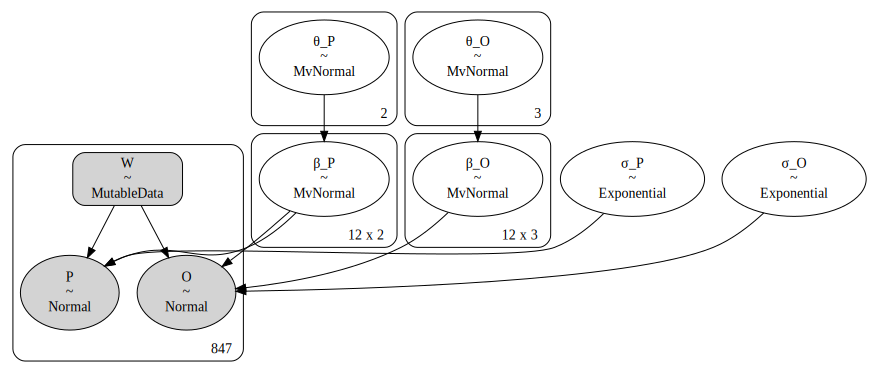

In [14]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

In [12]:
prior_2 = az.InferenceData.from_netcdf(model_2_dir / 'prior')
posterior_2 = az.InferenceData.from_netcdf(model_2_dir / 'posterior')
posterior_prediction_2 = az.InferenceData.from_netcdf(model_2_dir / 'posterior_prediction')

## Prior predictive check

Text(0, 0.5, 'μ_P')

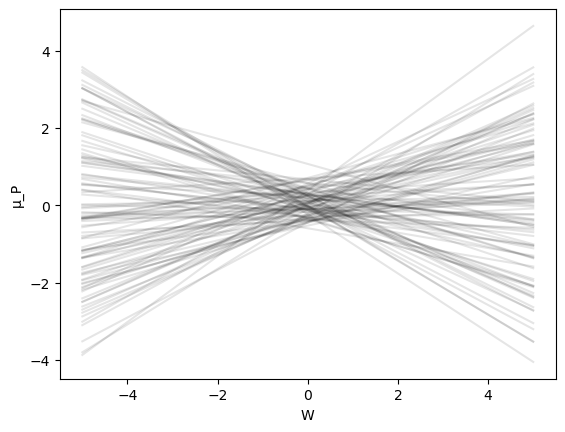

In [13]:
prior = prior_2['prior']
x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
y = prior['β_P'][:,:,0,0] + prior['β_P'][:,:,0,1] * x
_, ax = plt.subplots()
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
ax.set_xlabel('W')
ax.set_ylabel('μ_P')

Text(0, 0.5, 'μ_O')

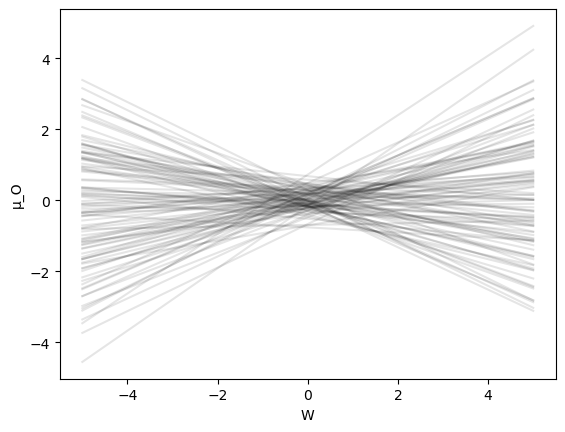

In [14]:
x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
y = prior['β_O'][:,:,0,0] + prior['β_O'][:,:,0,1] * x + prior['β_O'][:,:,0,2] * (prior['β_P'][:,:,0,0] + prior['β_P'][:,:,0,1] * x)
_, ax = plt.subplots()
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
ax.set_xlabel('W')
ax.set_ylabel('μ_O')

## Posterior predictive check

array([<AxesSubplot: xlabel='P / P'>, <AxesSubplot: xlabel='O / O'>],
      dtype=object)

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/antth/anaconda3/envs/socio-ethnic_segregation/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



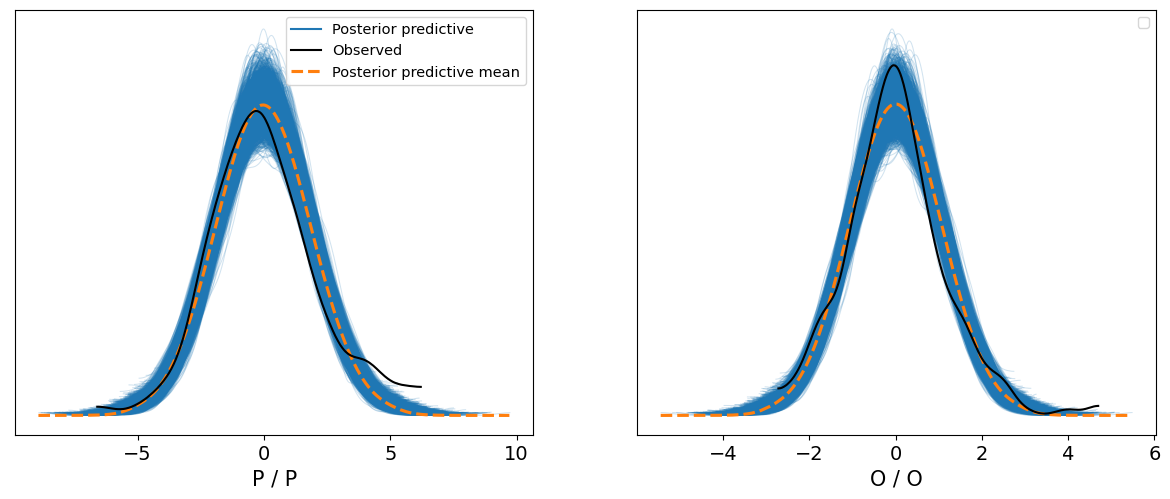

In [15]:
az.plot_ppc(posterior_prediction_2)

## Trace plots

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

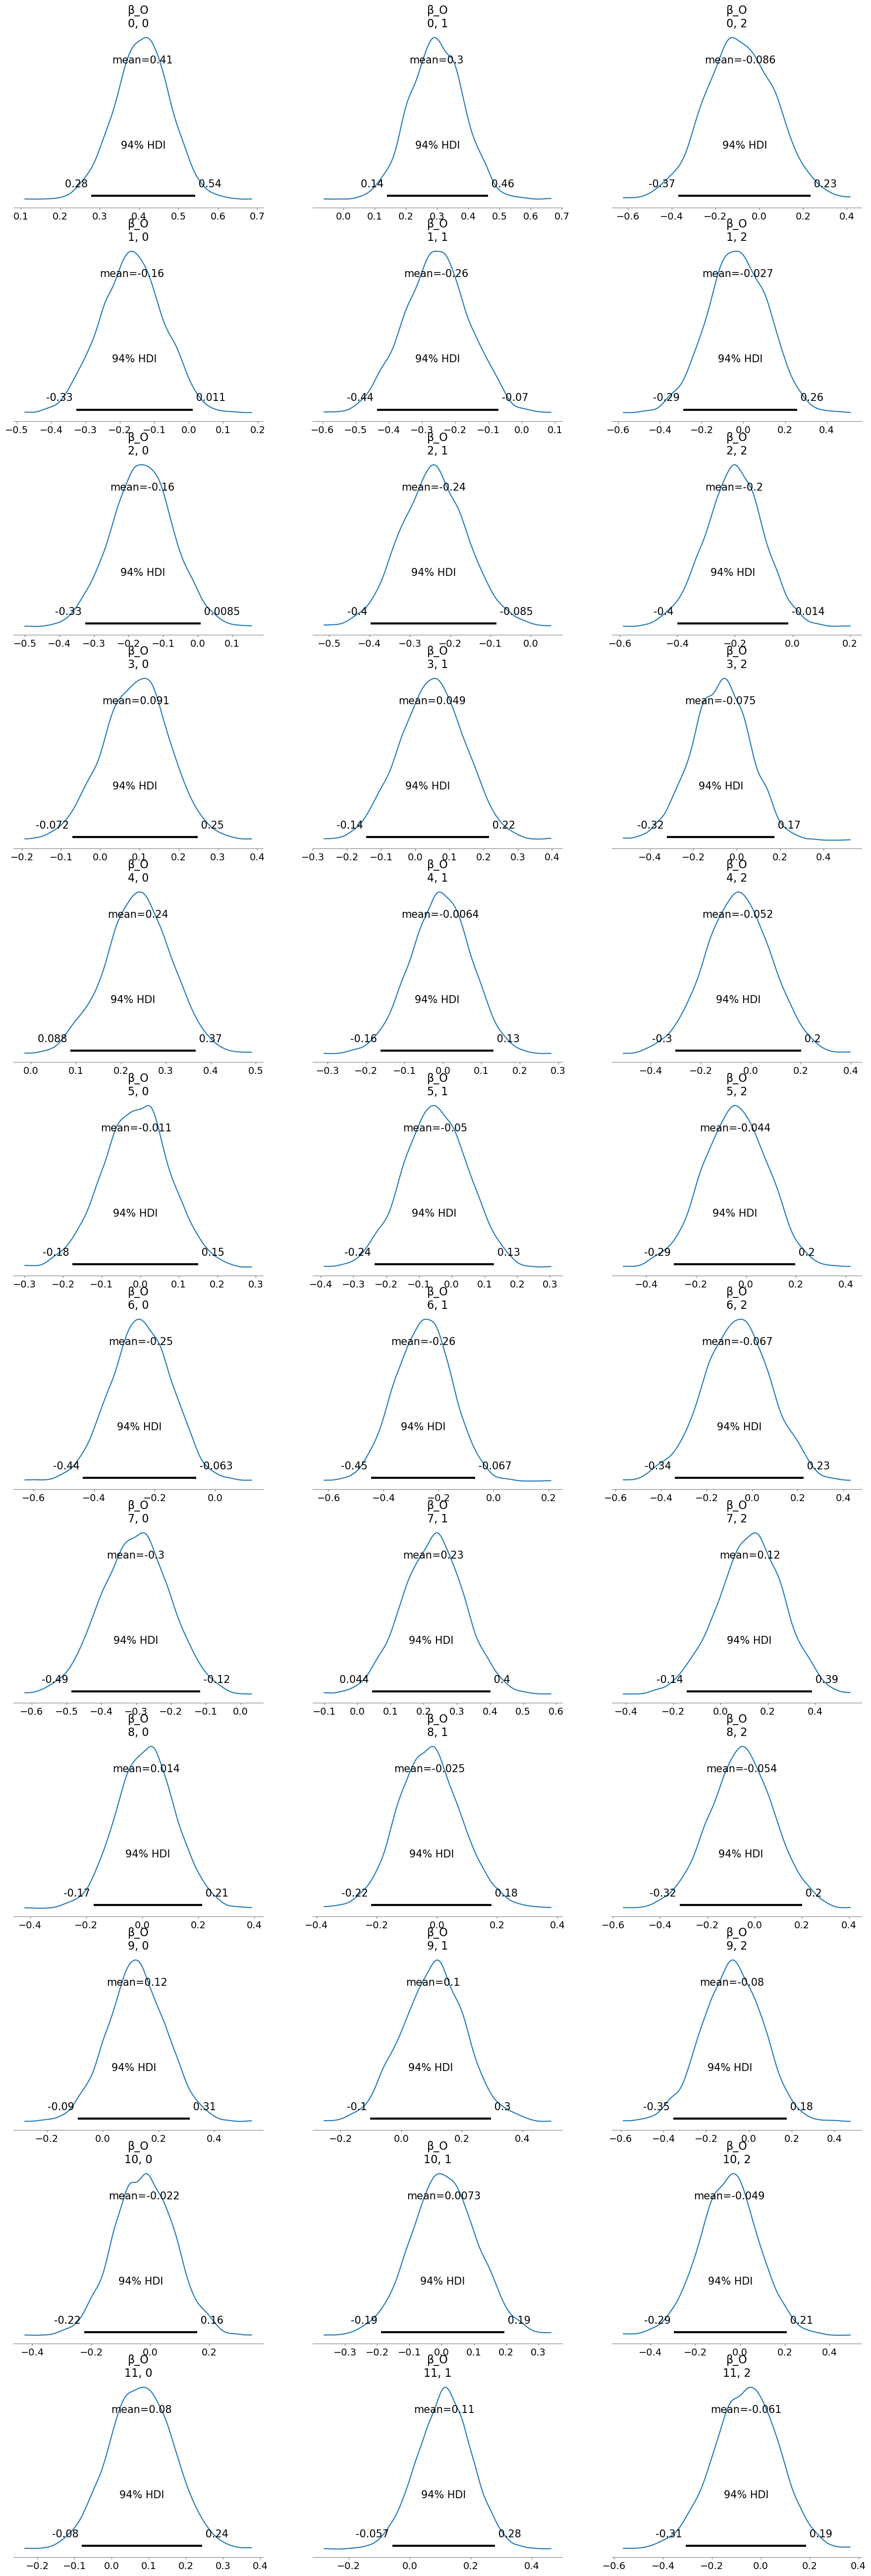

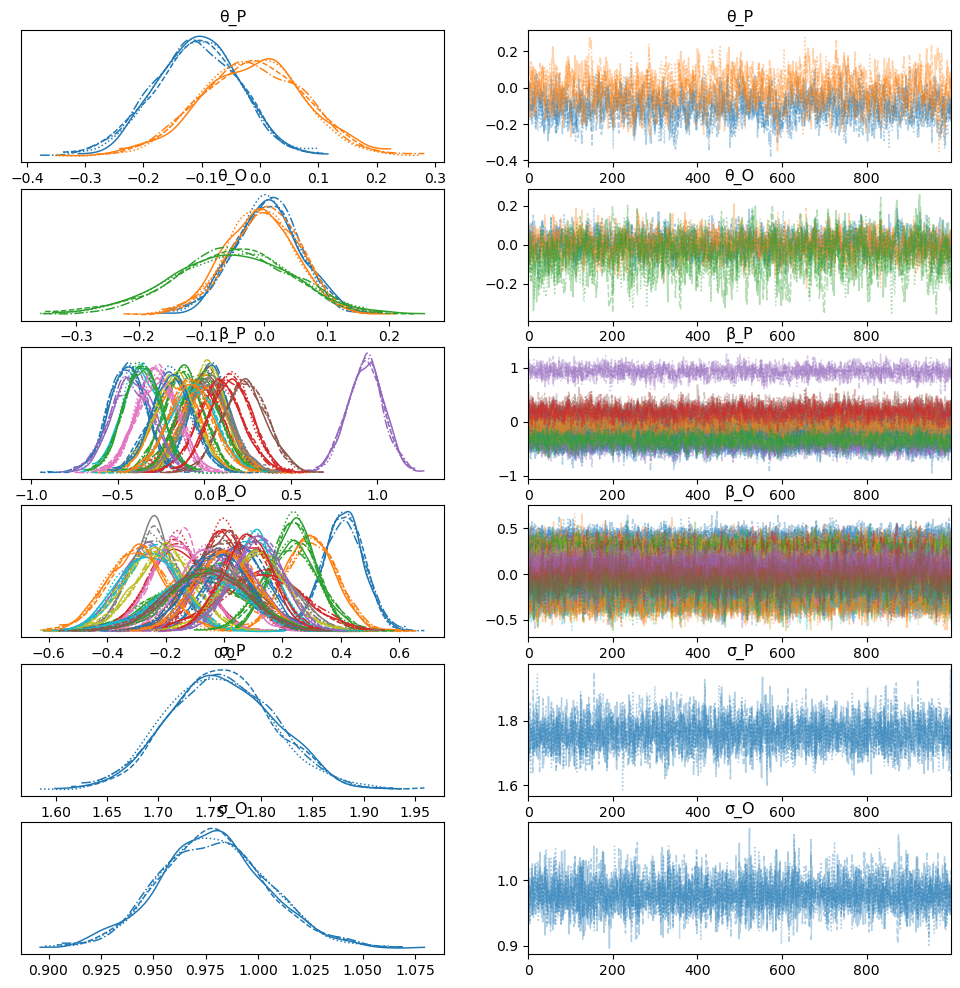

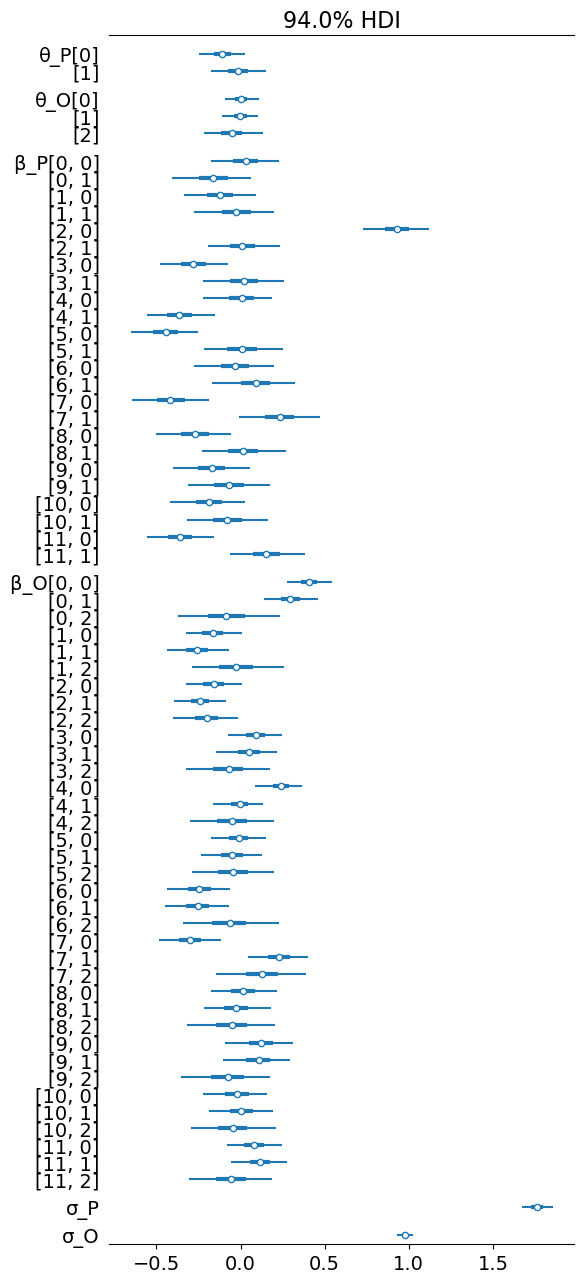

In [18]:
az.plot_posterior(posterior_2, var_names='β_O', grid=(12, 3))
az.plot_trace(posterior_2)
az.plot_forest(posterior_2, combined=True, hdi_prob=0.94)